In [9]:
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import d3p
from twinify.napsu_mq.napsu_mq import NapsuMQModel
from twinify.napsu_mq import rubins_rules as rubin
from twinify.napsu_mq import marginal_query
from twinify.napsu_mq.markov_network import MarkovNetwork
from twinify.napsu_mq import maximum_entropy_inference as mei
from twinify.napsu_mq import privacy_accounting
from tests.napsu_mq import lr
from tests.napsu_mq.binary_logistic_regression_generator import BinaryLogisticRegressionDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm

In [2]:
rng = d3p.random.PRNGKey(42526709)
data_gen_rng, inference_rng = d3p.random.split(rng)
data_gen_rng = d3p.random.convert_to_jax_rng_key(data_gen_rng)

In [3]:
n = 2000
d = 4
n_syn_datasets = 100
n_syn_dataset = n

epsilon = 1.0
delta = n**(-2)

conf_levels = np.linspace(0.05, 0.95, 19)
true_params = jnp.array((0.4, 0.3, 0.0))


def gen_data(rng):
    data_gen = BinaryLogisticRegressionDataGenerator(true_params)
    data = data_gen.generate_data(n, rng)
    x_values = data_gen.x_values
    values_by_feature = data_gen.values_by_feature

    return data, x_values, values_by_feature

def get_dp_suff_stat(rng, queries, data):
    suff_stat = jnp.sum(queries.flatten()(data), axis=0)
    sensitivity = np.sqrt(suff_stat.shape[0])
    sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)
    dp_suff_stat = suff_stat + sigma_DP * jax.random.normal(key=rng, shape=suff_stat.shape)
    return dp_suff_stat, sigma_DP

def record(ci, conf_level, dim, repeat_ind):
    return {
        "has_coverage": int(ci[0] <= true_params[dim].item() <= ci[1]),
        "conf_level": conf_level,
        "dim": dim,
        "repeat_ind": repeat_ind
    }

In [5]:
n_repeats = 50
records = []
rng = d3p.random.PRNGKey(74249069)
rngs = d3p.random.split(rng, n_repeats)

for i in tqdm(range(n_repeats)):
    data_rng, inference_rng, sampling_rng = d3p.random.split(rngs[i], 3)
    data_rng = d3p.random.convert_to_jax_rng_key(data_rng)
    
    data, x_values, values_by_feature = gen_data(data_rng)
    data = pd.DataFrame(data, dtype="int")

    model = NapsuMQModel(column_feature_set=[tuple(range(d))], use_laplace_approximation=False)
    result = model.fit(
        data=data,
        rng=inference_rng,
        epsilon=epsilon,
        delta=delta,
        query_sets=[tuple(range(d))]
    )

    synthetic_dfs = result.generate(
        rng=sampling_rng, 
        num_data_per_parameter_sample=n_syn_dataset, 
        num_parameter_samples=n_syn_datasets,
        single_dataframe=False
    )

    syn_datasets = np.stack(synthetic_dfs, axis=0)

    q, u = lr.logistic_regression(syn_datasets, add_constant=False)
    for j in range(d - 1):
        for conf_level in conf_levels:
            qi = q[:,j]
            ui = u[:,j]
            inds = (np.isfinite(qi) & np.isfinite(ui))
            qi = qi[inds]
            ui = ui[inds]
            ci = rubin.conf_int(qi, ui, conf_level)
            records.append(record(ci, conf_level, j, i))


df = pd.DataFrame.from_records(records)

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 29589.45it/s]


4it [00:00, 31011.49it/s]


2it [00:00, 36954.22it/s]


4it [00:00, 30783.88it/s]


8it [00:00, 26929.72it/s]


8it [00:00, 25078.05it/s]


4it [00:00, 39945.75it/s]


8it [00:00, 32640.50it/s]


8it [00:00, 34485.54it/s]


4it [00:00, 22489.57it/s]


2it [00:00, 15060.34it/s]


4it [00:00, 38130.04it/s]


16it [00:00, 14720.08it/s]


2it [00:00, 34952.53it/s]


2it [00:00, 34952.53it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 905.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

4it [00:00, 31956.60it/s]


2it [00:00, 35246.25it/s]


4it [00:00, 45100.04it/s]


8it [00:00, 31271.60it/s]


8it [00:00, 25991.04it/s]


4it [00:00, 43919.41it/s]


8it [00:00, 32640.50it/s]


8it [00:00, 38479.85it/s]


4it [00:00, 37701.61it/s]


2it [00:00, 23237.14it/s]


4it [00:00, 38479.85it/s]


16it [00:00, 15823.83it/s]


2it [00:00, 33420.75it/s]


2it [00:00, 31300.78it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 942.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 833.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38836.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 55764.73it/s]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 373.06it/s, 15 steps of size 2.45e-01. acc. prob=0.88]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 58603.05it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 366.48it/s, 7 steps of size 3.29e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4353.15it/s, 7 steps of size 2.67e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4236.16it/s, 7 steps of size 2.63e-01. acc. prob=0.92]

  0%|                                                                                                                                               

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 351.14it/s, 7 steps of size 1.89e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3728.14it/s, 7 steps of size 1.37e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4034.94it/s, 7 steps of size 2.17e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 27822.91it/s]


4it [00:00, 40820.48it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 41221.66it/s]


8it [00:00, 31987.07it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 366.20it/s, 7 steps of size 2.09e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4162.38it/s, 7 steps of size 2.12e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4002.26it/s, 7 steps of size 2.69e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31775.03it/s]


4it [00:00, 45964.98it/s]


2it [00:00, 16008.79it/s]


4it [00:00, 43577.18it/s]


8it [00:00, 25477.93it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 367.79it/s, 7 steps of size 1.24e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3759.22it/s, 7 steps of size 2.33e-01. acc. prob=0.83]

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3935.40it/s, 79 steps of size 1.59e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31011.49it/s]


4it [00:00, 42581.77it/s]


2it [00:00, 33825.03it/s]


4it [00:00, 44384.17it/s]


8it [00:00, 20008.61it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 376.56it/s, 7 steps of size 3.09e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4395.52it/s, 7 steps of size 3.50e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4303.93it/s, 7 steps of size 3.50e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40329.85it/s]


4it [00:00, 32513.98it/s]


2it [00:00, 36954.22it/s]


4it [00:00, 30783.88it/s]


8it [00:00, 31625.29it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 374.83it/s, 7 steps of size 2.46e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4254.98it/s, 7 steps of size 2.85e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4002.51it/s, 7 steps of size 2.58e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 36954.22it/s]


4it [00:00, 37701.61it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 34239.22it/s]


8it [00:00, 16225.55it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 372.02it/s, 7 steps of size 2.91e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4228.99it/s, 7 steps of size 1.46e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4225.60it/s, 7 steps of size 2.49e-01. acc. prob=0.87]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 30783.88it/s]


4it [00:00, 43351.98it/s]


2it [00:00, 13336.42it/s]


4it [00:00, 43018.50it/s]


8it [00:00, 32513.98it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 369.56it/s, 7 steps of size 3.18e-01. acc. prob=0.82]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4202.52it/s, 7 steps of size 2.09e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4093.51it/s, 7 steps of size 2.79e-01. acc. prob=0.84]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38479.85it/s]


4it [00:00, 28976.19it/s]


2it [00:00, 18850.80it/s]


4it [00:00, 40041.09it/s]


8it [00:00, 29852.70it/s]


8it [00:

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4228.43it/s, 23 steps of size 2.13e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4292.33it/s, 7 steps of size 2.41e-01. acc. prob=0.89]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 35394.97it/s]


4it [00:00, 40427.03it/s]


2it [00:00, 16100.98it/s]


4it [00:00, 42048.16it/s]


8it [00:00, 31242.49it/s]


8it [00:00, 26672.84it/s]


4it [00:00, 40820.48it/s]


8it [00:00, 33487.46it/s]


8it [00:00, 23814.36it/s]


4it [00:00, 37701.61it/s]


2it [00:00, 33961.98it/s]


4it [00:00, 38926.26it/s]


16it [00:00, 16840.37it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4051.75it/s, 7 steps of size 2.24e-01. acc. prob=0.91]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4141.79it/s, 7 steps of size 2.64e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 29026.33it/s]


4it [00:00, 44034.69it/s]


2it [00:00, 14290.64it/s]


4it [00:00, 39568.91it/s]


8it [00:00, 17163.39it/s]


8it [00:00, 18305.75it/s]


4it [00:00, 27413.75it/s]


8it [00:00, 23188.96it/s]


8it [00:00, 20056.44it/s]


4it [00:00, 23109.11it/s]


2it [00:00, 31775.03it/s]


4it [00:00, 22459.46it/s]


16it [00:00, 16627.57it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4147.26it/s, 7 steps of size 2.26e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4191.07it/s, 7 steps of size 2.40e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40427.03it/s]


4it [00:00, 37365.74it/s]


2it [00:00, 21290.88it/s]


4it [00:00, 32017.59it/s]


8it [00:00, 31126.56it/s]


8it [00:00, 20610.83it/s]


4it [00:00, 39945.75it/s]


8it [00:00, 32171.08it/s]


8it [00:00, 29203.16it/s]


4it [00:00, 37449.14it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 36002.61it/s]


16it [00:00, 20416.45it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4203.07it/s, 7 steps of size 2.59e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4132.74it/s, 7 steps of size 2.57e-01. acc. prob=0.87]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40820.48it/s]


4it [00:00, 34521.02it/s]


2it [00:00, 15621.24it/s]


4it [00:00, 42581.77it/s]


8it [00:00, 35062.10it/s]


8it [00:00, 26337.86it/s]


4it [00:00, 47527.52it/s]


8it [00:00, 35848.75it/s]


8it [00:00, 37076.72it/s]


4it [00:00, 32704.12it/s]


2it [00:00, 31775.03it/s]


4it [00:00, 33893.37it/s]


16it [00:00, 18941.25it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4422.68it/s, 7 steps of size 3.18e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 33026.02it/s]


4it [00:00, 31536.12it/s]


2it [00:00, 16644.06it/s]


4it [00:00, 39199.10it/s]


8it [00:00, 33091.16it/s]


8it [00:00, 23125.04it/s]


4it [00:00, 33961.98it/s]


8it [00:00, 34309.24it/s]


8it [00:00, 22133.53it/s]


4it [00:00, 33893.37it/s]


2it [00:00, 39016.78it/s]


4it [00:00, 36631.48it/s]


16it [00:00, 20014.57it/s]


2it [00:00, 39945.75it/s]


2it [00:00, 15141.89it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4330.72it/s, 15 steps of size 3.35e-01. acc. prob=0.86]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39290.90it/s]


4it [00:00, 22857.24it/s]


2it [00:00, 32263.88it/s]


4it [00:00, 37957.50it/s]


8it [00:00, 28876.45it/s]


8it [00:00, 32800.03it/s]


4it [00:00, 42581.77it/s]


8it [00:00, 26051.58it/s]


8it [00:00, 35135.53it/s]


4it [00:00, 36711.63it/s]


2it [00:00, 41943.04it/s]


4it [00:00, 35320.45it/s]


16it [00:00, 20026.52it/s]


2it [00:00, 38479.85it/s]


2it [00:00, 39945.75it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3903.81it/s, 7 steps of size 1.37e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 30283.78it/s]


4it [00:00, 41221.66it/s]


2it [00:00, 22250.95it/s]


4it [00:00, 43464.29it/s]


8it [00:00, 29177.77it/s]


8it [00:00, 20299.11it/s]


4it [00:00, 22459.46it/s]


8it [00:00, 24546.04it/s]


8it [00:00, 25381.57it/s]


4it [00:00, 42908.48it/s]


2it [00:00, 32263.88it/s]


4it [00:00, 34169.48it/s]


16it [00:00, 14134.13it/s]


2it [00:00, 37617.08it/s]


2it [00:00, 35246.25it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4309.14it/s, 3 steps of size 2.94e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 28008.71it/s]


4it [00:00, 41630.81it/s]


2it [00:00, 39945.75it/s]


4it [00:00, 32832.13it/s]


8it [00:00, 31447.45it/s]


8it [00:00, 15470.00it/s]


4it [00:00, 20610.83it/s]


8it [00:00, 26255.42it/s]


8it [00:00, 17791.32it/s]


4it [00:00, 36393.09it/s]


2it [00:00, 36954.22it/s]


4it [00:00, 29228.60it/s]


16it [00:00, 14184.92it/s]


2it [00:00, 36314.32it/s]


2it [00:00, 36314.32it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3683.68it/s, 7 steps of size 2.91e-01. acc. prob=0.85]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31655.12it/s]


4it [00:00, 41221.66it/s]


2it [00:00, 40136.88it/s]


4it [00:00, 30504.03it/s]


8it [00:00, 36873.00it/s]


8it [00:00, 29203.16it/s]


4it [00:00, 39290.90it/s]


8it [00:00, 34592.20it/s]


8it [00:00, 30066.70it/s]


4it [00:00, 45964.98it/s]


2it [00:00, 37617.08it/s]


4it [00:00, 25343.23it/s]


16it [00:00, 19978.82it/s]


2it [00:00, 38130.04it/s]


2it [00:00, 39199.10it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4036.26it/s, 7 steps of size 1.76e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 41221.66it/s]


4it [00:00, 37701.61it/s]


2it [00:00, 40136.88it/s]


4it [00:00, 44979.13it/s]


8it [00:00, 33756.97it/s]


8it [00:00, 33756.97it/s]


4it [00:00, 36314.32it/s]


8it [00:00, 37076.72it/s]


8it [00:00, 28173.33it/s]


4it [00:00, 39568.91it/s]


2it [00:00, 40920.04it/s]


4it [00:00, 38836.15it/s]


16it [00:00, 20808.95it/s]


2it [00:00, 15141.89it/s]


2it [00:00, 40920.04it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31242.49it/s]


4it [00:00, 38746.46it/s]


2it [00:00, 36314.32it/s]


4it [00:00, 48629.61it/s]


8it [00:00, 34309.24it/s]


8it [00:00, 30066.70it/s]


4it [00:00, 42048.16it/s]


8it [00:00, 34204.31it/s]


8it [00:00, 30202.01it/s]


4it [00:00, 33354.31it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 24350.10it/s]


16it [00:00, 20860.70it/s]


2it [00:00, 38479.85it/s]


2it [00:00, 39945.75it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1069.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 35696.20it/s]


4it [00:00, 44384.17it/s]


2it [00:00, 34952.53it/s]


4it [00:00, 40041.09it/s]


8it [00:00, 25247.88it/s]


8it [00:00, 28292.10it/s]


4it [00:00, 47662.55it/s]


8it [00:00, 34309.24it/s]


8it [00:00, 25134.41it/s]


4it [00:00, 42048.16it/s]


2it [00:00, 40136.88it/s]


4it [00:00, 34807.50it/s]


16it [00:00, 20050.45it/s]


2it [00:00, 38479.85it/s]


2it [00:00, 16946.68it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1069.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40041.09it/s]


4it [00:00, 39662.45it/s]


2it [00:00, 36314.32it/s]


4it [00:00, 42153.81it/s]


8it [00:00, 34807.50it/s]


8it [00:00, 23188.96it/s]


4it [00:00, 32832.13it/s]


8it [00:00, 31242.49it/s]


8it [00:00, 22841.68it/s]


4it [00:00, 38130.04it/s]


2it [00:00, 37786.52it/s]


4it [00:00, 39662.45it/s]


16it [00:00, 20280.71it/s]


2it [00:00, 40524.68it/s]


2it [00:00, 15738.48it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1087.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 34450.14it/s]


4it [00:00, 42153.81it/s]


2it [00:00, 16163.02it/s]


4it [00:00, 43464.29it/s]


8it [00:00, 32109.50it/s]


8it [00:00, 32768.00it/s]


4it [00:00, 49932.19it/s]


8it [00:00, 28387.84it/s]


8it [00:00, 24157.26it/s]


4it [00:00, 37449.14it/s]


2it [00:00, 43690.67it/s]


4it [00:00, 48072.25it/s]


16it [00:00, 19092.14it/s]


2it [00:00, 28630.06it/s]


2it [00:00, 39945.75it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1063.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39199.10it/s]


4it [00:00, 40041.09it/s]


2it [00:00, 15505.74it/s]


4it [00:00, 42581.77it/s]


8it [00:00, 21399.51it/s]


8it [00:00, 23730.15it/s]


4it [00:00, 32832.13it/s]


8it [00:00, 31506.51it/s]


8it [00:00, 25153.25it/s]


4it [00:00, 29382.16it/s]


2it [00:00, 35246.25it/s]


4it [00:00, 46474.28it/s]


16it [00:00, 20050.45it/s]


2it [00:00, 34521.02it/s]


2it [00:00, 44620.26it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1057.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38836.15it/s]


4it [00:00, 33354.31it/s]


2it [00:00, 35098.78it/s]


4it [00:00, 31476.95it/s]


8it [00:00, 32928.79it/s]


8it [00:00, 33893.37it/s]


4it [00:00, 41630.81it/s]


8it [00:00, 37914.61it/s]


8it [00:00, 23188.96it/s]


4it [00:00, 44384.17it/s]


2it [00:00, 13911.46it/s]


4it [00:00, 37035.80it/s]


16it [00:00, 20329.86it/s]


2it [00:00, 42366.71it/s]


2it [00:00, 42366.71it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1083.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 21129.99it/s]


4it [00:00, 33354.31it/s]


2it [00:00, 36954.22it/s]


4it [00:00, 45964.98it/s]


8it [00:00, 28339.89it/s]


8it [00:00, 31242.49it/s]


4it [00:00, 40427.03it/s]


8it [00:00, 32513.98it/s]


8it [00:00, 32263.88it/s]


4it [00:00, 39290.90it/s]


2it [00:00, 34952.53it/s]


4it [00:00, 47662.55it/s]


16it [00:00, 19703.13it/s]


2it [00:00, 37786.52it/s]


2it [00:00, 35098.78it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1090.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 32017.59it/s]


4it [00:00, 39945.75it/s]


2it [00:00, 35696.20it/s]


4it [00:00, 40427.03it/s]


8it [00:00, 35544.95it/s]


8it [00:00, 28055.55it/s]


4it [00:00, 43018.50it/s]


8it [00:00, 30283.78it/s]


8it [00:00, 24690.53it/s]


4it [00:00, 38043.57it/s]


2it [00:00, 40721.40it/s]


4it [00:00, 22104.37it/s]


16it [00:00, 18803.27it/s]


2it [00:00, 6710.89it/s]


2it [00:00, 38479.85it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1026.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38479.85it/s]


4it [00:00, 38836.15it/s]


2it [00:00, 37117.73it/s]


4it [00:00, 31536.12it/s]


8it [00:00, 33354.31it/s]


8it [00:00, 29433.71it/s]


4it [00:00, 21732.15it/s]


8it [00:00, 33058.55it/s]


8it [00:00, 36041.28it/s]


4it [00:00, 45343.83it/s]


2it [00:00, 40920.04it/s]


4it [00:00, 19901.80it/s]


16it [00:00, 21223.55it/s]


2it [00:00, 37117.73it/s]


2it [00:00, 37786.52it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1057.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 34521.02it/s]


4it [00:00, 40041.09it/s]


2it [00:00, 33961.98it/s]


4it [00:00, 45466.71it/s]


8it [00:00, 33058.55it/s]


8it [00:00, 24690.53it/s]


4it [00:00, 34169.48it/s]


8it [00:00, 21440.53it/s]


8it [00:00, 27280.03it/s]


4it [00:00, 33961.98it/s]


2it [00:00, 29026.33it/s]


4it [00:00, 43351.98it/s]


16it [00:00, 20648.88it/s]


2it [00:00, 40721.40it/s]


2it [00:00, 40524.68it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1079.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

4it [00:00, 39662.45it/s]


2it [00:00, 16256.99it/s]


4it [00:00, 44384.17it/s]


8it [00:00, 23061.47it/s]


8it [00:00, 26951.35it/s]


4it [00:00, 36002.61it/s]


8it [00:00, 34771.43it/s]


8it [00:00, 28556.96it/s]


4it [00:00, 47662.55it/s]


2it [00:00, 40920.04it/s]


4it [00:00, 43018.50it/s]


16it [00:00, 19157.54it/s]


2it [00:00, 37117.73it/s]


2it [00:00, 39756.44it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1074.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55924.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1078.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59074.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 56191.63it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 370.96it/s, 7 steps of size 2.13e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 50928.24it/s]

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 366.46it/s, 7 steps of size 2.89e-01. acc. prob=0.85]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4165.30it/s, 7 steps of size 2.09e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4232.95it/s, 7 steps of size 2.89e-01. acc. prob=0.88]

  0%|                                                                                                                                               

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 372.16it/s, 7 steps of size 2.81e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4184.84it/s, 7 steps of size 2.46e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4224.41it/s, 7 steps of size 2.44e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 33621.68it/s]


4it [00:00, 38836.15it/s]


2it [00:00, 37617.08it/s]


4it [00:00, 36792.14it/s]


8it [00:00, 35135.53it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 370.58it/s, 7 steps of size 3.34e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4349.97it/s, 7 steps of size 3.65e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4389.74it/s, 7 steps of size 3.11e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31775.03it/s]


4it [00:00, 40721.40it/s]


2it [00:00, 31775.03it/s]


4it [00:00, 14755.69it/s]


8it [00:00, 30393.51it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 370.92it/s, 7 steps of size 1.38e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4075.64it/s, 7 steps of size 2.18e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4058.36it/s, 7 steps of size 1.57e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 40920.04it/s]


4it [00:00, 40136.88it/s]


2it [00:00, 23831.27it/s]


4it [00:00, 45964.98it/s]


8it [00:00, 30868.84it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 366.34it/s, 7 steps of size 1.37e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4008.38it/s, 7 steps of size 1.75e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4055.10it/s, 7 steps of size 1.47e-01. acc. prob=0.90]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 31775.03it/s]


4it [00:00, 37365.74it/s]


2it [00:00, 32140.26it/s]


4it [00:00, 40820.48it/s]


8it [00:00, 30559.59it/s]


8it [00:

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:07<00:00, 363.53it/s, 7 steps of size 2.26e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4023.36it/s, 7 steps of size 2.43e-01. acc. prob=0.90]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4065.08it/s, 7 steps of size 2.16e-01. acc. prob=0.91]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 37035.80it/s]


4it [00:00, 39568.91it/s]


2it [00:00, 34952.53it/s]


4it [00:00, 30338.55it/s]


8it [00:00, 27302.22it/s]


8it [00:

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4214.92it/s, 7 steps of size 2.70e-01. acc. prob=0.89]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4328.83it/s, 7 steps of size 3.00e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 39475.80it/s]


4it [00:00, 37786.52it/s]


2it [00:00, 35696.20it/s]


4it [00:00, 39945.75it/s]


8it [00:00, 35062.10it/s]


8it [00:00, 35062.10it/s]


4it [00:00, 42153.81it/s]


8it [00:00, 34204.31it/s]


8it [00:00, 33156.55it/s]


4it [00:00, 30727.50it/s]


2it [00:00, 29746.84it/s]


4it [00:00, 21290.88it/s]


16it [00:00, 21852.45it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4090.41it/s, 7 steps of size 1.82e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 3816.37it/s, 7 steps of size 2.16e-01. acc. prob=0.83]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 35098.78it/s]


4it [00:00, 42048.16it/s]


2it [00:00, 33288.13it/s]


4it [00:00, 43464.29it/s]


8it [00:00, 34485.54it/s]


8it [00:00, 33621.68it/s]


4it [00:00, 39290.90it/s]


8it [00:00, 30531.79it/s]


8it [00:00, 34030.86it/s]


4it [00:00, 49344.75it/s]


2it [00:00, 39945.75it/s]


4it [00:00, 45964.98it/s]


16it [00:00, 20329.86it/s

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4315.94it/s, 15 steps of size 2.10e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4274.97it/s, 7 steps of size 2.61e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38479.85it/s]


4it [00:00, 27235.74it/s]


2it [00:00, 14588.88it/s]


4it [00:00, 35025.50it/s]


8it [00:00, 31359.28it/s]


8it [00:00, 30202.01it/s]


4it [00:00, 32326.04it/s]


8it [00:00, 35394.97it/s]


8it [00:00, 33756.97it/s]


4it [00:00, 38479.85it/s]


2it [00:00, 41734.37it/s]


4it [00:00, 30283.78it/s]


16it [00:00, 20919.22it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4363.06it/s, 7 steps of size 3.20e-01. acc. prob=0.87]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4274.33it/s, 7 steps of size 3.06e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 30504.03it/s]


4it [00:00, 44501.90it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 35394.97it/s]


8it [00:00, 31625.29it/s]


8it [00:00, 30393.51it/s]


4it [00:00, 37365.74it/s]


8it [00:00, 33487.46it/s]


8it [00:00, 38435.78it/s]


4it [00:00, 46474.28it/s]


2it [00:00, 29026.33it/s]


4it [00:00, 20636.18it/s]


16it [00:00, 18325.74it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4149.59it/s, 7 steps of size 2.38e-01. acc. prob=0.88]

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4107.58it/s, 7 steps of size 2.13e-01. acc. prob=0.91]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38479.85it/s]


4it [00:00, 31476.95it/s]


2it [00:00, 14290.64it/s]


4it [00:00, 34239.22it/s]


8it [00:00, 29641.72it/s]


8it [00:00, 23530.46it/s]


4it [00:00, 35696.20it/s]


8it [00:00, 31359.28it/s]


8it [00:00, 24036.13it/s]


4it [00:00, 23663.21it/s]


2it [00:00, 43464.29it/s]


4it [00:00, 36472.21it/s]


16it [00:00, 20757.46it/s

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4048.18it/s, 7 steps of size 1.39e-01. acc. prob=0.91]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 37701.61it/s]


4it [00:00, 33554.43it/s]


2it [00:00, 40721.40it/s]


4it [00:00, 42473.96it/s]


8it [00:00, 25950.84it/s]


8it [00:00, 32109.50it/s]


4it [00:00, 37365.74it/s]


8it [00:00, 29537.35it/s]


8it [00:00, 29407.92it/s]


4it [00:00, 38479.85it/s]


2it [00:00, 40136.88it/s]


4it [00:00, 20841.26it/s]


16it [00:00, 20566.61it/s]


2it [00:00, 40721.40it/s]


2it [00:00, 40920.04it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4206.10it/s, 7 steps of size 2.29e-01. acc. prob=0.89]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38479.85it/s]


4it [00:00, 37701.61it/s]


2it [00:00, 12826.62it/s]


4it [00:00, 37365.74it/s]


8it [00:00, 36551.67it/s]


8it [00:00, 23205.00it/s]


4it [00:00, 40136.88it/s]


8it [00:00, 29382.16it/s]


8it [00:00, 30421.06it/s]


4it [00:00, 37786.52it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 37786.52it/s]


16it [00:00, 19027.18it/s]


2it [00:00, 35848.75it/s]


2it [00:00, 40920.04it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4220.03it/s, 31 steps of size 2.97e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 29177.77it/s]


4it [00:00, 33354.31it/s]


2it [00:00, 38479.85it/s]


4it [00:00, 30338.55it/s]


8it [00:00, 30755.67it/s]


8it [00:00, 25324.10it/s]


4it [00:00, 36314.32it/s]


8it [00:00, 34309.24it/s]


8it [00:00, 33058.55it/s]


4it [00:00, 48770.98it/s]


2it [00:00, 40721.40it/s]


4it [00:00, 36080.03it/s]


16it [00:00, 20002.64it/s]


2it [00:00, 41527.76it/s]


2it [00:00, 39756.44it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 4395.37it/s, 7 steps of size 3.15e-01. acc. prob=0.88]

  0%|                                                                                                                                                                                       | 0/16 [00:00<?, ?it/s]

4it [00:00, 38836.15it/s]


4it [00:00, 46474.28it/s]


2it [00:00, 12965.39it/s]


4it [00:00, 39945.75it/s]


8it [00:00, 23865.17it/s]


8it [00:00, 24403.22it/s]


4it [00:00, 45964.98it/s]


8it [00:00, 35283.31it/s]


8it [00:00, 24018.92it/s]


4it [00:00, 48913.17it/s]


2it [00:00, 39016.78it/s]


4it [00:00, 37365.74it/s]


16it [00:00, 18431.44it/s]


2it [00:00, 41734.37it/s]


2it [00:00, 40721.40it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [14:05<00:00, 16.91s/it]


In [6]:
df

,has_coverage,conf_level,dim,repeat_ind
0,0,0.05,0,0
1,0,0.10,0,0
2,0,0.15,0,0
3,0,0.20,0,0
4,0,0.25,0,0
...,...,...,...,...
2845,1,0.75,2,49
2846,1,0.80,2,49
2847,1,0.85,2,49
2848,1,0.90,2,49


There may be a memory leak, as the process took 6.51GB of memory at the end, even with the `del` statements in the code.

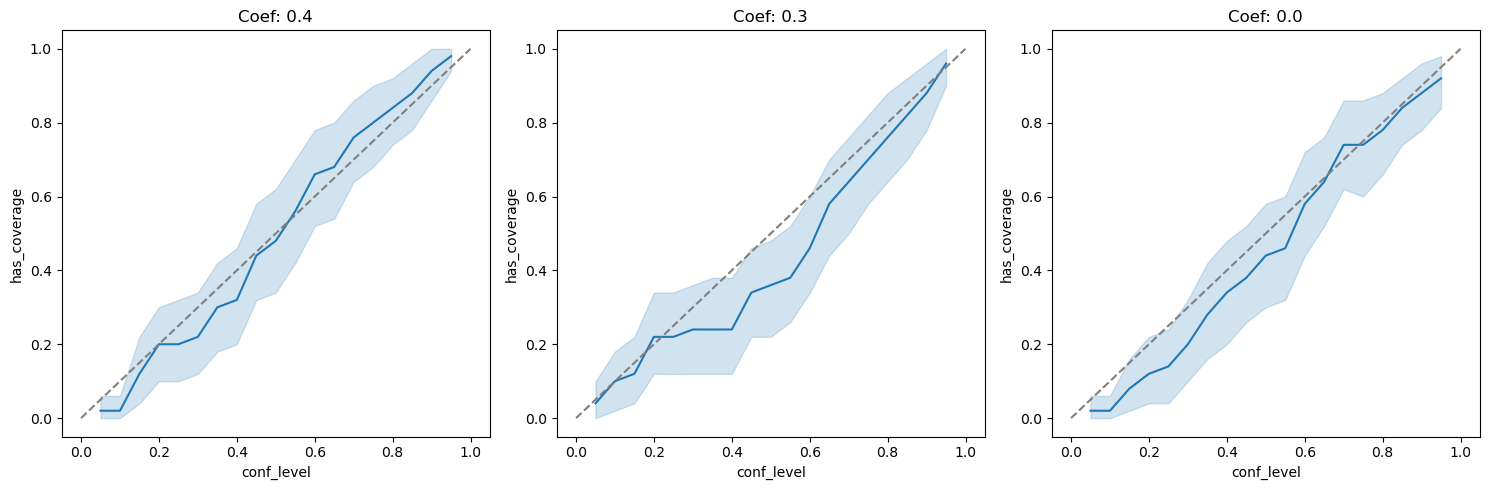

In [8]:
fig, axes = plt.subplots(1, d - 1, figsize=(5 * (d - 1), 5))
for i in range(d - 1):
    cdf = df[df.dim == i]
    ax = axes[i]
    sns.lineplot(data=cdf, x="conf_level", y="has_coverage", ax=ax)
    ax.plot((0, 1), (0, 1), linestyle="dashed", color="grey")
    ax.set_title("Coef: {}".format(true_params[i].item()))

plt.tight_layout()
plt.savefig("napsu-mq-coverage.pdf")
plt.show()